In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization, Dropout, Reshape, Input, Lambda
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import time
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt



2024-09-30 13:47:24.706132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 13:47:24.793661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 13:47:24.817992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 13:47:24.999655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 13:47:26.870134: W tensorflow/compiler/tf2

In [2]:
class CLM():
    def __init__(self, layers, n_chars, dropouts, trainables,lr):
        self.layers = layers
        self.n_chars = n_chars
        self.dropouts = dropouts
        self.trainables = trainables
        self.lr = lr
        self.model = None
        self.build_model()
    def build_model(self):
        # create a squential model and assigned to self.model
        self.model = Sequential()
        # Add a BatchNormalization layer input layer, input shape should be None, number of characters
        self.model.add(BatchNormalization(input_shape = (None,self.n_chars)))
        
        # Add n LSTM layers, where n is defined by the variable layers. This will be a list of ints where each int is the number of units in the LSTM layer. i.e [256, 512] will add two layers with 256 and 512 neurons respectively
        # This loop should also include the dropout values contained in the dropouts variable (list of floats). 
        # And it should also include the trainable parameter from the trainables variable (list of booleans). 
        print(self.layers)
        for i in range(len(self.layers)):
            if i ==len(self.layers)-1:
                print(self.layers[i], "False")
                self.model.add(LSTM(units=self.layers[i], trainable=self.trainables[i], return_sequences=False, dropout=self.dropouts[i]))
            else:
                print(self.layers[i], "True")
                self.model.add(LSTM(units=self.layers[i], trainable=self.trainables[i], return_sequences=True, dropout=self.dropouts[i]))
            
        # add another BatchNormalization layer, this time no need to specify input shape
        self.model.add(BatchNormalization())
        # Finally add an output layer, it should be a Dense layer with n_chars units and softmax activation. Also, this layer should be containd in a TimeDistributed layer, so that it can be applied to each character in the sequence.

        # compile the model with Adam optimizer and categorical_crossentropy loss. Don't forget to set the learning rate to the value contained in the lr variable with optimizer = Adam(learning_rate=self.lr)
        optimizer = Adam(learning_rate=self.lr)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [3]:
#Same model as above but with a classifer head added 
class SeqModel():
    def __init__(self, layers, n_chars, dropouts, trainables, lr):
        self.layers = layers
        self.n_chars = n_chars
        self.dropouts = dropouts
        self.trainables = trainables
        self.lr = lr
        self.model = None
        self.build_model()
        
    def build_model(self):
        # Core (shared)
        LM_input = Input(shape=(None, self.n_chars), name='LM_input')
        x = BatchNormalization()(LM_input)
        
        n_iter = 0
        for neurons, dropout, trainable in zip(self.layers, self.dropouts, self.trainables):
            if n_iter==len(self.layers)-1:
                x = LSTM(neurons,
                     unit_forget_bias=True,
                     dropout=dropout,
                     trainable=trainable,
                     return_sequences=False)(x)
            else:
                x = LSTM(neurons,
                         unit_forget_bias=True,
                         dropout=dropout,
                         trainable=trainable,
                         return_sequences=True)(x)
            n_iter+=1
            
        x = BatchNormalization()(x)
        
        # Head
        r = Dropout(0.3)(x)                    
        # Ranked classification, so sigmoid and
        # multiple outputs
        head_output = Dense(3, 
                            name='head_output',
                            activation='sigmoid')(r)
        # Join
        self.model = Model(inputs=[LM_input], outputs=[head_output])
        
        # Compile
        optimizer = Adam(learning_rate=self.lr)
        self.model.compile(optimizer=optimizer,
                           loss='binary_crossentropy')

    

In [4]:
import re
import numpy as np
import keras

#Fixed parameters
PROCESSING_FIXED = {'start_char': 'G', 
                    'end_char': 'E', 
                    'pad_char': 'A'}

INDICES_TOKEN = {0: 'c',
                 1: 'C',
                 2: '(',
                 3: ')',
                 4: 'O',
                 5: '1',
                 6: '2',
                 7: '=',
                 8: 'N',
                 9: '@',
                 10: '[',
                 11: ']',
                 12: 'n',
                 13: '3',
                 14: 'H',
                 15: 'F',
                 16: '4',
                 17: '-',
                 18: 'S',
                 19: 'Cl',
                 20: '/',
                 21: 's',
                 22: 'o',
                 23: '5',
                 24: '+',
                 25: '#',
                 26: '\\',
                 27: 'Br',
                 28: 'P',
                 29: '6',
                 30: 'I',
                 31: '7',
                 32: PROCESSING_FIXED['start_char'],
                 33: PROCESSING_FIXED['end_char'],
                 34: PROCESSING_FIXED['pad_char']}                
TOKEN_INDICES = {v: k for k, v in INDICES_TOKEN.items()}

def smi_tokenizer(smi):
    """
    Tokenize a SMILES
    """
    pattern =  "(\[|\]|Xe|Ba|Rb|Ra|Sr|Dy|Li|Kr|Bi|Mn|He|Am|Pu|Cm|Pm|Ne|Th|Ni|Pr|Fe|Lu|Pa|Fm|Tm|Tb|Er|Be|Al|Gd|Eu|te|As|Pt|Lr|Sm|Ca|La|Ti|Te|Ac|Si|Cf|Rf|Na|Cu|Au|Nd|Ag|Se|se|Zn|Mg|Br|Cl|U|V|K|C|B|H|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%\d{2}|\d)"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]

    return tokens        

class onehotencoder():
    def __init__(self, max_chars=90):
        # here we define the class variables that will be used in the functions. If we want to use them in the class, we need to use self. in front of the variable name
        # then when we want to use the class variable in the function, we pass self as the first argument to the function and we can access the class variables
        self.max_chars = max_chars
    def smiles_to_num(self, smiles):
        tokens = smi_tokenizer(smiles)
        tokens = [PROCESSING_FIXED['start_char']] + tokens +[PROCESSING_FIXED['end_char']]
        tokens+= [PROCESSING_FIXED['pad_char']]* (self.max_chars-len(tokens))
        num_tokens = [TOKEN_INDICES[t] for t in tokens]
        #print(tokens)
        #create numbers
        return np.asarray(tokens) #Return the numbers as a numpy array
    def num_to_onehot(self,tokens):
        onehot = np.zeros((len(tokens), len(INDICES_TOKEN)))
        for i,token in enumerate(tokens):
            onehot[i, TOKEN_INDICES[token]] = 1
        return onehot
        #This function will convert the numbers to one hot encoding. It should take a list of numbers and return a list of one hot encoded vectors with the shape (max_chars, 35)
    def generate_data(self, smiles):
        nums = self.smiles_to_num(smiles)
        data = self.num_to_onehot(nums)
        return np.asarray(data)
        #This function should take a list of smiles strings and return a numpy array of one hot encoded vectors with the shape (number of smiles, max_chars, 35)
        #You can use the smiles_to_num and num_to_onehot functions to help you with this
        #This function will be used to generate the training and validation data


In [5]:
chem_model = load_model(f'../pretraining/LSTM/{48:03d}.keras') #load the model from file
print('model loaded')

I0000 00:00:1727700452.972533     571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727700453.180824     571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727700453.180897     571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727700453.191684     571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727700453.191792     571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

model loaded


In [7]:
beta = pd.read_csv('beta_activity_class.csv') #Clean CSV file with beta secretase smiles and activity
beta["activity_class"].value_counts()
#dropna of activity_class
beta = beta.dropna(subset=["activity_class"])
#transfor activity_class to 0,1,2
beta["activity_class"] = beta["activity_class"].replace("moderately_active", 1)
beta["activity_class"] = beta["activity_class"].replace("inactive", 0)
beta["activity_class"] = beta["activity_class"].replace("very_active", 2)


/tmp/ipykernel_571/3666820747.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  beta["activity_class"] = beta["activity_class"].replace("very_active", 2)


In [8]:
beta

,Ligand SMILES,activity_class
0,CCSc1cnc(cn1)C(=O)Nc1cccc(c1)[C@]1(C)CCSC(N)=N1,1
1,C[C@]1(CCSC(N)=N1)c1cc(NC(=O)CCc2ccc(O)c(O)c2)...,1
2,COc1nc(nc(C)c1F)N1C[C@H]2C(=O)N(C)C(=N)N[C@]2(...,1
3,COc1nc(nc(C)c1F)N1C[C@H]2C(=O)N(C)C(=N)N[C@]2(...,1
4,COc1nc(nc(C)c1F)N1C[C@H]2C(=O)N(C)C(=N)N[C@]2(...,1
...,...,...
15992,FC(F)(F)c1ccc(N\N=C\c2coc3cc4oc(cc4cc3c2=O)-c2...,0
15993,COc1ccc(cc1)-c1cc2cc3c(cc2o1)occ(\C=N\Nc1ccc(c...,0
15994,COc1ccc(CN(CCN(C)CCN)c2ccccn2)cc1,0
15995,Fc1cccc(c1)-c1cc2c(ccc3c2occ(\C=N\Nc2ccc(cc2)C...,0


In [9]:
#Also, remove any smiles string that contains a character NOT in our vocabulary (excluding pad, start and end chars). Hint: allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
beta = beta[beta['Ligand SMILES'].apply(lambda x: all(char in allowed_chars for char in x))]
#drop data longer than 90 characters
beta = beta[beta['Ligand SMILES'].apply(lambda x: len(x)<=90)]

In [10]:
beta

,Ligand SMILES,activity_class
0,CCSc1cnc(cn1)C(=O)Nc1cccc(c1)[C@]1(C)CCSC(N)=N1,1
1,C[C@]1(CCSC(N)=N1)c1cc(NC(=O)CCc2ccc(O)c(O)c2)...,1
2,COc1nc(nc(C)c1F)N1C[C@H]2C(=O)N(C)C(=N)N[C@]2(...,1
5,Nc1ccc2ccccc2n1,0
6,Nc1cccc(CCc2ccccc2)n1,0
...,...,...
15991,Fc1cccc(c1)-c1cc2cc3c(cc2o1)occ(\C=N\Nc1ccc(cc...,0
15993,COc1ccc(cc1)-c1cc2cc3c(cc2o1)occ(\C=N\Nc1ccc(c...,0
15994,COc1ccc(CN(CCN(C)CCN)c2ccccn2)cc1,0
15995,Fc1cccc(c1)-c1cc2c(ccc3c2occ(\C=N\Nc2ccc(cc2)C...,0


In [11]:
#compile the new model
layers = [1024,256]
dropouts = [0.40, 0.40]
trainables = [True, True]
lr = 0.001
epochs = 80
new_model = CLM(
    layers=layers,
    dropouts=dropouts,
    trainables=trainables,
    lr=lr,
    n_chars=35
    )
print('model created')


/home/scro4068/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[1024, 256]
1024 True
256 False
model created


In [12]:
chem_model.layers

[<BatchNormalization name=batch_normalization_2, built=True>,
 <LSTM name=lstm_2, built=True>,
 <LSTM name=lstm_3, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <TimeDistributed name=time_distributed_1, built=True>]

In [13]:
new_model.model.layers

[<BatchNormalization name=batch_normalization, built=True>,
 <LSTM name=lstm, built=True>,
 <LSTM name=lstm_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>]

In [14]:
#Set the weights of the pretrained model to the new model
n_l_pre = len(chem_model.layers)
for i,layer in enumerate(chem_model.layers):
    if i!=n_l_pre-1:
        weights = layer.get_weights()
        idx_layer = i
        new_model.model.layers[idx_layer].set_weights(weights)
        print(f'Pretrained layer {i} loaded in layer {idx_layer}')

Pretrained layer 0 loaded in layer 0
Pretrained layer 1 loaded in layer 1
Pretrained layer 2 loaded in layer 2
Pretrained layer 3 loaded in layer 3


In [21]:
#Data upsampling using random oversampling to fix class imbalance. See https://www.ibm.com/topics/upsampling#:~:text=Upsampling%20increases%20the%20number%20of,and%20thereby%20improve%20model%20performance.
def up_sample(data, target, dict_n):
    """
    Return an up sampled version of 
    data and target according to dict_n
    - Dict_n (dict): 
        key: class to augment
        value: n data to randomly sample
    """
    
    # form a dict with key:class, value:idx_smi
    dict_byclass_smi = {}
    i=0
    for smi,clas in zip(data,target):
        if clas in dict_byclass_smi:
            dict_byclass_smi[clas].append(i)
        else:
            dict_byclass_smi[clas] = [i]
        i+=1
    
    smi_to_add = []
    tar_to_add = []
    for class_,n in dict_n.items():
        if n>0:
            for n_ in range(n):
                idx_picked = np.random.choice(dict_byclass_smi[class_])
                smi_to_add.append(data[idx_picked])
                tar_to_add.append(target[idx_picked])
                
    return data+smi_to_add, target+tar_to_add

In [19]:
beta['activity_class'].value_counts() #Samples per class before upsampling

activity_class
1    6591
2    1638
0    1071
Name: count, dtype: int64

In [22]:
#Upsample the data, add 5000 to class 0 and class 2
upvalues = [5000,0,5000]
dict_upvalues = dict(enumerate(upvalues))
print(f'\nUp values dict: ', dict_upvalues)
tr_input, tr_output = up_sample(beta['Ligand SMILES'].values.tolist(), beta['activity_class'].values.tolist(), dict_upvalues)


Up values dict:  {0: 5000, 1: 0, 2: 5000}


In [23]:
new_df = pd.DataFrame({'Ligand SMILES':tr_input, 'activity_class':tr_output})

In [24]:
new_df['activity_class'].value_counts() #Samples per class after upsampling

activity_class
2    6638
1    6591
0    6071
Name: count, dtype: int64

In [25]:
#list with the one hot vectors of the smiles
encoder = onehotencoder(max_chars=92)
smiles_arr = [encoder.generate_data(s) for s in new_df['Ligand SMILES']]
inputs_x = np.zeros((new_df.shape[0],92,35))
for i in range(new_df.shape[0]):
    inputs_x[i] = smiles_arr[i]

In [16]:
#Convert the label to ordinal regression, this will give the model an idea of the order of the classes
def convert(label, n_output):
    if n_output==3:
        conv_dict = {0:np.array([1,0,0]),
                    1:np.array([1,1,0]),
                    2:np.array([1,1,1])}
    return conv_dict[label]

In [31]:
beta['activity_class'][0] #Original label

1

In [27]:
labels = [convert(b, 3) for b in new_df['activity_class']] 
labels = np.array(labels)
labels.shape

(19300, 3)

In [111]:
labels[0] #Converted label

array([1, 1, 0])

In [22]:
'''X_train, X_test, y_train, y_test = train_test_split(features, new_df['activity_class'].values, test_size=0.2)
#get the indices of the test and train data
train_indices = np.where(np.isin(features, X_train).all(axis=1))[0]
test_indices = np.where(np.isin(features, X_test).all(axis=1))[0]
np.savetxt('train_indices.csv', train_indices, delimiter=',')
np.savetxt('test_indices.csv', test_indices, delimiter=',')'''

In [28]:
#Data was split, but I saved the indices of each split to keep the same data across different models
train_indices = np.loadtxt('train_indices.csv', delimiter=',', dtype=int)
test_indices = np.loadtxt('test_indices.csv', delimiter=',', dtype=int)

/tmp/ipykernel_571/46384760.py:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  train_indices = np.loadtxt('train_indices.csv', delimiter=',', dtype=int)
/tmp/ipykernel_571/46384760.py:2: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it

In [48]:
#select the features of the train and test data by the indices
X_train = inputs_x[train_indices]
X_test =  inputs_x[test_indices]  
#select the labels of the train and test data by the indices
y_train = labels[train_indices] 
y_test = labels[test_indices] 

In [17]:
#compile the new model
layers = [1024,256]
dropouts = [0.40, 0.40]
trainables = [True, True]
lr = 0.0001
epochs = 80
seqmodel = SeqModel(
    layers=layers,
    dropouts=dropouts,
    trainables=trainables,
    lr=lr,
    n_chars=35
    )
print('model created')

model created


In [18]:
#Set the weights of the pretrained model to the new model
n_l_pre = len(chem_model.layers)
for i,layer in enumerate(chem_model.layers):
    if i!=n_l_pre-1:
        weights = layer.get_weights()
        # +1 because of the input layer added
        layer_shift = 1
        idx_layer = i+layer_shift
        seqmodel.model.layers[idx_layer].set_weights(weights)
        print(f'Pretrained layer {i} loaded in layer {idx_layer}')

Pretrained layer 0 loaded in layer 1
Pretrained layer 1 loaded in layer 2
Pretrained layer 2 loaded in layer 3
Pretrained layer 3 loaded in layer 4


In [33]:
#Fit the model
history = seqmodel.model.fit(x=X_train,
                                         y=np.array(y_train),
                                         epochs=200,
                                         batch_size=20,
                                         shuffle=True,
                                         validation_split=0.2,
                                         callbacks=[ModelCheckpoint(filepath='LSTM_ft.keras',
               monitor='val_loss',save_best_only=True,mode='min')])

Epoch 1/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - loss: 0.1179 - val_loss: 0.2113
Epoch 2/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 0.1124 - val_loss: 0.2046
Epoch 3/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.1112 - val_loss: 0.1838
Epoch 4/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 0.1152 - val_loss: 0.2028
Epoch 5/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 0.1085 - val_loss: 0.2008
Epoch 6/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.1151 - val_loss: 0.1363
Epoch 7/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.1110 - val_loss: 0.2363
Epoch 8/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.1054 - val_loss: 0.2393
Epoch 9/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.1051 - val_loss: 0.1915
Epoch 10/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - loss: 0.1096 - val_loss: 0.1851
Epoch 11/200
618/618 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.1028 - val_loss: 0.1904
Epoch 12/200
618/61

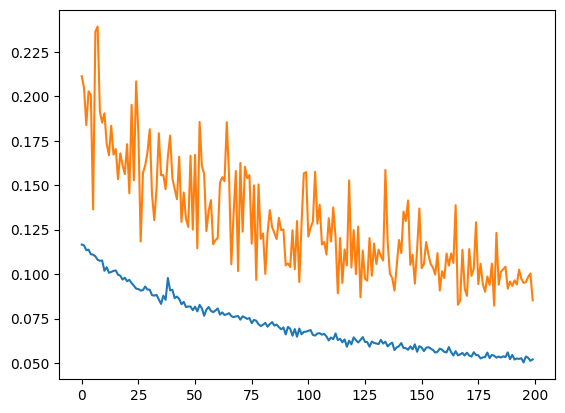

In [34]:
#Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [36]:
#get best epoch
best_epoch = np.argmin(history.history['val_loss'])
print(f'Best epoch: {best_epoch}')


Best epoch: 182


In [49]:
y_pred = seqmodel.model.predict(X_test)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [59]:
#Calculate the accuracy
from sklearn.metrics import accuracy_score
#Transform the predictions to the class
y_class_pred = np.round(np.sum(y_pred, axis=1)) #Sum the probabilities of the classes and round to the nearest integer to get the class as 0,1,2
y_class_test = np.round(np.sum(y_test, axis=1)) #Sum the probabilities of the classes and round to the nearest integer to get the class as 0,1,2
accuracy_score(y_class_pred, y_class_test) #Calculate the accuracy

0.8974093264248705

In [38]:
#Transform the class into a one hot encoding to plot the ROC curve. See https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(new_df['activity_class'].values[train_indices])
y_onehot_test = label_binarizer.transform(new_df['activity_class'].values[test_indices])
y_onehot_test.shape  # (n_samples, n_classes)

(3860, 3)

In [39]:
class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

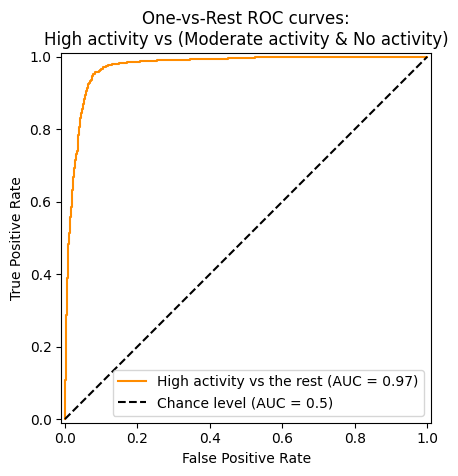

In [55]:
#Plot the ROC curve for the class of interest (High activity vs the rest)
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"High activity vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nHigh activity vs (Moderate activity & No activity)",
)

In [26]:
#predict from smiles arr and get the last hidden state of the LSTM
hidden = chem_model.predict(inputs_x)
hidden.shape
features = hidden.reshape(new_df.shape[0], -1)

2024-09-30 13:50:40.706436: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


604/604 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step


In [63]:
#select the features of the train and test data by the indices
X_train_rf = features[train_indices]
X_test_rf =  features[test_indices]  
#select the labels of the train and test data by the indices
y_train_rf = new_df["activity_class"][train_indices] 
y_test_rf = new_df["activity_class"][test_indices] 

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf)


rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)


y_pred_rf = rf_model.predict(X_test_rf)
print(classification_report(y_test_rf, y_pred_rf))

from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_test_rf, y_pred_rf)}')



              precision    recall  f1-score   support

           0       0.82      0.60      0.69      1229
           1       0.58      0.50      0.54      1310
           2       0.61      0.84      0.70      1321

    accuracy                           0.65      3860
   macro avg       0.67      0.64      0.64      3860
weighted avg       0.66      0.65      0.64      3860

Accuracy: 0.6463730569948186
